In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

pd.options.display.precision = 2

# Read in ICA blinks for merged raws from all subjects

In [2]:
eog_peaks = {}
fs_Hz = 64.0

for subjectID in range(1, 21+1):
    npy_path = f'../../eog_peaks_sub{subjectID}_merged_raws.npy'
    arr = np.load(npy_path, allow_pickle=True)
    arr = arr.flat[0]
    eog_peaks[subjectID] = arr[subjectID]


Helper functions to extract relevant info from imported npy ICA data:

In [73]:
# Convert dt object to float seconds
def dtToSeconds(row):
    return row.minute * 60.0 + row.second + (row.microsecond / 1e6)

def descToCondition(row):
    if 'Listening' in row:
        condition = 'Listening' 
    else:
        condition = 'Imagery'
    return condition

def descToChorale(row):
    return row.split('-')[-1]

# Count number of blinks
def countBlinks(subjectID, onset_s, duration, eog_peaks, fs_Hz = 64.0):
    trial_end_s = onset_s + duration
    
    ica_eog_events = np.float64(eog_peaks[subjectID]['ica_eog_events'])
    #print(ica_eog_events)
    ica_eog_events /= fs_Hz
    
    num_blinks = sum((onset_s < ica_eog_events) & (ica_eog_events < trial_end_s))
    return num_blinks

In [74]:
df_all = pd.DataFrame()

for subjectID in eog_peaks:
    # Convert MNE annotations for start/duration time stamp of each trial to a dataframe
    df = eog_peaks[subjectID]['trial_annots'].to_data_frame()

    # Add subjectID as a column (for when we concat all subject dataframes)
    df['subjectID'] = subjectID

    # Drop annotations from merging rawArrays for each trial
    df = df[(df['description'] != 'BAD boundary') & (df['description'] != 'EDGE boundary')]

    # Add trial index as a column
    df['trial'] = range(88)

    # Only retain the time from datetime objects for 'onset'
    df['onset_s'] = df['onset'].apply(
        dtToSeconds
    )

    df['blinks'] = df.apply(
        lambda x: countBlinks(x['subjectID'], x['onset_s'], x['duration'], eog_peaks, fs_Hz), 
        axis = 1,
    )

    df_all = pd.concat([df_all, df])

# Reset row indices so they now count up from 0 to 87 (88 trials total)
df_all.reset_index(
    inplace=True, # modify df indices in place
    drop=True, # do not add a new index column
)

df_all['condition'] = df_all['description'].apply(
    descToCondition,
)

df_all['chorale'] = df_all['description'].apply(
    descToChorale,
)

# Rename "description" (from annotations) to "condition"
# df_all = df_all.rename(columns={"description": "condition"})
df_all

,onset,duration,description,subjectID,trial,onset_s,blinks,condition,chorale
0,1970-01-01 00:00:00.000000,28.16,Listening/chor-096,1,0,0.00,10,Listening,096
1,1970-01-01 00:00:28.171875,28.16,Listening/chor-096,1,1,28.17,5,Listening,096
2,1970-01-01 00:00:56.343750,28.16,Listening/chor-038,1,2,56.34,8,Listening,038
3,1970-01-01 00:01:24.515625,28.16,Listening/chor-038,1,3,84.52,8,Listening,038
4,1970-01-01 00:01:52.687500,28.16,Listening/chor-101,1,4,112.69,4,Listening,101
...,...,...,...,...,...,...,...,...,...
1843,1970-01-01 00:38:58.265625,28.16,Imagery/chor-096,21,83,2338.27,1,Imagery,096
1844,1970-01-01 00:39:26.437500,28.16,Imagery/chor-038,21,84,2366.44,3,Imagery,038
1845,1970-01-01 00:39:54.609375,28.16,Imagery/chor-038,21,85,2394.61,3,Imagery,038
1846,1970-01-01 00:40:22.781250,28.16,Imagery/chor-019,21,86,2422.78,1,Imagery,019


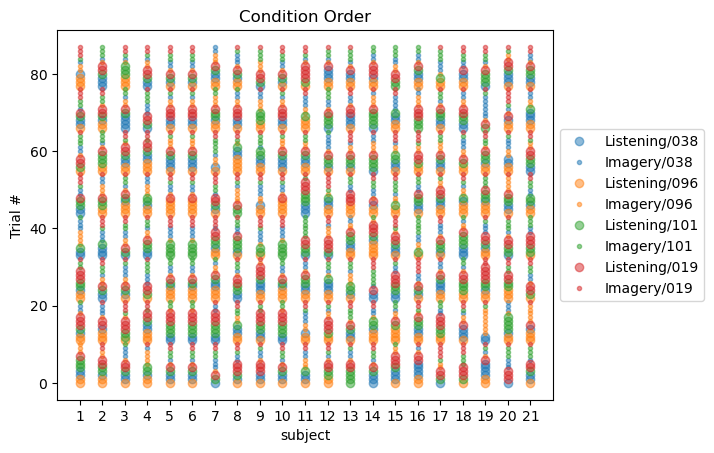

In [192]:
fig, ax = plt.subplots()

for chorale in ['038', '096', '101', '019']:
    df = df_all[(df_all['condition'] == 'Listening') & (df_all['chorale'] == chorale)]
    line, = ax.plot(
        df['subjectID'],
        df['trial'],
        marker = 'o',
        ls = '',
        label = f'Listening/{chorale}',
        alpha=0.5,
    )

    df = df_all[(df_all['condition'] == 'Imagery') & (df_all['chorale'] == chorale)]
    ax.plot(
        df['subjectID'],
        df['trial'],
        marker = '.',
        ls = '',
        c = line.get_color(),
        label = f'Imagery/{chorale}',
        alpha=0.5,
    )

plt.xticks(
    ticks = range(1, 21+1)
)
plt.title('Condition Order')
plt.xlabel('subject')
plt.ylabel('Trial #')
plt.legend(bbox_to_anchor=(1., .75))
plt.show()

# Pivot Table To Get Mean / Median Blink Counts
By condition (description) and subject

In [75]:
df_pivot = pd.pivot_table(
    df_all,
    values = 'blinks',
    index = 'subjectID',
    columns = ['condition', 'chorale'],
    aggfunc = ['mean', 'median', 'sum']
)

df_pivot

mean                                                      median  \
condition Imagery                      Listening                      Imagery   
chorale       019    038    096    101       019    038    096    101     019   
subjectID                                                                       
1            3.91   9.00   6.82   5.91      6.45   8.09   7.82   7.64       4   
2            0.45   0.18   0.55   0.09      0.18   0.82   0.64   0.55       0   
3            0.91   3.09   2.45   2.91      4.91   8.00   5.64   5.91       1   
4            3.00   3.64   2.55   3.73      3.55   7.91   4.45   7.36       2   
5            0.64   0.73   0.55   0.45      0.45   1.55   0.91   2.64       0   
6            1.82   6.36   4.73   3.55      2.09   6.55   7.27   3.55       1   
7           10.45  19.73  18.00  14.18     13.91  22.45  19.36  17.18      10   
8            0.00   0.27   0.00   0.00      0.18   0.00   0.18   0.00       0   
9            1.45   1.00   1.55   0.91      2.36   2.00   1.91   0.73       2   
10           1.64   2.18   1.82   1.45      1.36   2.91   2.00   1.36       2   
11           3.36   5.18   5.91   2.82      3.18   5.64   6.00   5.00       3   
12           2.00   2.55   1.09   1.55      0.91   2.00   1.55   0.55       0   
13           0.36   0.55   0.82   0.36      2.27   4.73   3.64   3.00       0   
14           0.00   0.09   0.18   0.00      0.45   3.64   1.09   0.27       0   
15           0.18   0.73   0.27   0.45      0.09   0.36   0.18   0.55       0   
16           0.00   0.09   0.00   0.00      0.00   0.00   0.00   0.09       0   
17           3.45   5.27   5.82   5.09     11.27  13.82  21.18  10.55       3   
18           1.36   1.00   1.27   1.18      1.55   1.18   1.36   1.27       1   
19           0.00   0.00   0.00   0.00      0.27   0.00   0.00   0.00       0   
20           0.64   1.00   0.55   1.18      0.55   1.55   1.09   1.09       0   
21           0.91   2.00   1.27   2.09      2.09   4.18   1.09   1.73       1   

               ...                   sum                                     \
condition      ... Listening     Imagery                Listening             
chorale   038  ...       096 101     019  038  096  101       019  038  096   
subjectID      ...                                                            
1           9  ...         8   8      43   99   75   65        71   89   86   
2           0  ...         0   0       5    2    6    1         2    9    7   
3           4  ...         6   6      10   34   27   32        54   88   62   
4           3  ...         5   8      33   40   28   41        39   87   49   
5           0  ...         1   1       7    8    6    5         5   17   10   
6           6  ...         6   2      20   70   52   39        23   72   80   
7          19  ...        19  19     115  217  198  156       153  247  213   
8           0  ...         0   0       0    3    0    0         2    0    2   
9           1  ...         1   1      16   11   17   10        26   22   21   
10          2  ...         2   1      18   24   20   16        15   32   22   
11          5  ...         5   5      37   57   65   31        35   62   66   
12          2  ...         1   0      22   28   12   17        10   22   17   
13          0  ...         4   3       4    6    9    4        25   52   40   
14          0  ...         1   0       0    1    2    0         5   40   12   
15          0  ...         0   0       2    8    3    5         1    4    2   
16          0  ...         0   0       0    1    0    0         0    0    0   
17          4  ...        24   7      38   58   64   56       124  152  233   
18          1  ...         1   1      15   11   14   13        17   13   15   
19          0  ...         0   0       0    0    0    0         3    0    0   
20          1  ...         1   1       7   11    6   13         6   17   12   
21          2  ...         1   2      10   22   14   23        23   46   12   

           

In [76]:
# Sort subjectIDs by sum of blinks
conds_in_asc_blink_sum = df_pivot['sum'].sum(axis=0).sort_values().index
conds_in_asc_blink_sum

MultiIndex([(  'Imagery', '019'),
            (  'Imagery', '101'),
            (  'Imagery', '096'),
            ('Listening', '019'),
            (  'Imagery', '038'),
            ('Listening', '101'),
            ('Listening', '096'),
            ('Listening', '038')],
           names=['condition', 'chorale'])

In [77]:
subjectIDs_in_asc_blink_sum = df_pivot['sum'].sum(axis=1).sort_values().index
subjectIDs_in_asc_blink_sum

Int64Index([16, 19, 8, 15, 2, 14, 20, 5, 18, 9, 12, 10, 21, 13, 3, 6, 4, 11, 1,
            17, 7],
           dtype='int64', name='subjectID')

In [78]:
df_pivot['mean'][conds_in_asc_blink_sum]

condition Imagery               Listening Imagery Listening              
chorale       019    101    096       019     038       101    096    038
subjectID                                                                
1            3.91   5.91   6.82      6.45    9.00      7.64   7.82   8.09
2            0.45   0.09   0.55      0.18    0.18      0.55   0.64   0.82
3            0.91   2.91   2.45      4.91    3.09      5.91   5.64   8.00
4            3.00   3.73   2.55      3.55    3.64      7.36   4.45   7.91
5            0.64   0.45   0.55      0.45    0.73      2.64   0.91   1.55
6            1.82   3.55   4.73      2.09    6.36      3.55   7.27   6.55
7           10.45  14.18  18.00     13.91   19.73     17.18  19.36  22.45
8            0.00   0.00   0.00      0.18    0.27      0.00   0.18   0.00
9            1.45   0.91   1.55      2.36    1.00      0.73   1.91   2.00
10           1.64   1.45   1.82      1.36    2.18      1.36   2.00   2.91
11           3.36   2.82   5.91      3.18    5.18      5.00   6.00   5.64
12           2.00   1.55   1.09      0.91    2.55      0.55   1.55   2.00
13           0.36   0.36   0.82      2.27    0.55      3.00   3.64   4.73
14           0.00   0.00   0.18      0.45    0.09      0.27   1.09   3.64
15           0.18   0.45   0.27      0.09    0.73      0.55   0.18   0.36
16           0.00   0.00   0.00      0.00    0.09      0.09   0.00   0.00
17           3.45   5.09   5.82     11.27    5.27     10.55  21.18  13.82
18           1.36   1.18   1.27      1.55    1.00      1.27   1.36   1.18
19           0.00   0.00   0.00      0.27    0.00      0.00   0.00   0.00
20           0.64   1.18   0.55      0.55    1.00      1.09   1.09   1.55
21           0.91   2.09   1.27      2.09    2.00      1.73   1.09   4.18

In [79]:
df_pivot['mean'].loc[subjectIDs_in_asc_blink_sum, conds_in_asc_blink_sum]

condition Imagery               Listening Imagery Listening              
chorale       019    101    096       019     038       101    096    038
subjectID                                                                
16           0.00   0.00   0.00      0.00    0.09      0.09   0.00   0.00
19           0.00   0.00   0.00      0.27    0.00      0.00   0.00   0.00
8            0.00   0.00   0.00      0.18    0.27      0.00   0.18   0.00
15           0.18   0.45   0.27      0.09    0.73      0.55   0.18   0.36
2            0.45   0.09   0.55      0.18    0.18      0.55   0.64   0.82
14           0.00   0.00   0.18      0.45    0.09      0.27   1.09   3.64
20           0.64   1.18   0.55      0.55    1.00      1.09   1.09   1.55
5            0.64   0.45   0.55      0.45    0.73      2.64   0.91   1.55
18           1.36   1.18   1.27      1.55    1.00      1.27   1.36   1.18
9            1.45   0.91   1.55      2.36    1.00      0.73   1.91   2.00
12           2.00   1.55   1.09      0.91    2.55      0.55   1.55   2.00
10           1.64   1.45   1.82      1.36    2.18      1.36   2.00   2.91
21           0.91   2.09   1.27      2.09    2.00      1.73   1.09   4.18
13           0.36   0.36   0.82      2.27    0.55      3.00   3.64   4.73
3            0.91   2.91   2.45      4.91    3.09      5.91   5.64   8.00
6            1.82   3.55   4.73      2.09    6.36      3.55   7.27   6.55
4            3.00   3.73   2.55      3.55    3.64      7.36   4.45   7.91
11           3.36   2.82   5.91      3.18    5.18      5.00   6.00   5.64
1            3.91   5.91   6.82      6.45    9.00      7.64   7.82   8.09
17           3.45   5.09   5.82     11.27    5.27     10.55  21.18  13.82
7           10.45  14.18  18.00     13.91   19.73     17.18  19.36  22.45

In [83]:
stim_order = [
    ('Listening', '038'),
    ('Listening', '096'),
    ('Listening', '101'),
    ('Listening', '019'), 
    ('Imagery', '038'), 
    ('Imagery', '096'),
    ('Imagery', '101'), 
    ('Imagery', '019'), 
]

In [84]:
df_pivot['mean'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
).set_properties() #**{'font-size': '20px'}) 
# https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/ 

In [96]:
print(df_pivot['median'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
).to_latex(
        convert_css = True,
        column_format="r|c|c|c|c|c|c|c|c|",
        #hrules = True,
        clines = 'all;data',
        #multicol_align = {'c'},
    )
)

df_pivot['median'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
)

\begin{tabular}{r|c|c|c|c|c|c|c|c|}
condition & \multicolumn{4}{r}{Listening} & \multicolumn{4}{r}{Imagery} \\
chorale & 038 & 096 & 101 & 019 & 038 & 096 & 101 & 019 \\
subjectID &  &  &  &  &  &  &  &  \\
16 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 \\
\cline{1-9}
19 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1

In [151]:
print(df_pivot['sum'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='magma',
    axis = 1,
).to_latex(
    convert_css = True,
    column_format="r|c|c|c|c|c|c|c|c|",
    #hrules = True,
    clines = 'all;data',
    #multicol_align = {'c'},
    )
)

df_pivot['sum'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='magma',
    axis = 1,
)

\begin{tabular}{r|c|c|c|c|c|c|c|c|}
condition & \multicolumn{4}{r}{Listening} & \multicolumn{4}{r}{Imagery} \\
chorale & 038 & 096 & 101 & 019 & 038 & 096 & 101 & 019 \\
subjectID &  &  &  &  &  &  &  &  \\
16 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{FCFDBF}} \color[HTML]{000000} 1 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{FCFDBF}} \color[HTML]{000000} 1 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 \\
\cline{1-9}
19 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{FCFDBF}} \color[HTML]{000000} 3 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1

In [105]:
df_pivot['median'][stim_order]

condition Listening             Imagery            
chorale         038 096 101 019     038 096 101 019
subjectID                                          
1                 8   8   8   6       9   7   6   4
2                 1   0   0   0       0   0   0   0
3                 7   6   6   3       4   3   4   1
4                 8   5   8   2       3   2   3   2
5                 1   1   1   0       0   0   0   0
6                 6   6   2   2       6   5   3   1
7                23  19  19  14      19  19  15  10
8                 0   0   0   0       0   0   0   0
9                 2   1   1   1       1   1   1   2
10                2   2   1   1       2   2   1   2
11                5   5   5   3       5   6   3   3
12                2   1   0   0       2   1   1   0
13                5   4   3   2       0   1   0   0
14                3   1   0   0       0   0   0   0
15                0   0   0   0       0   0   0   0
16                0   0   0   0       0   0   0   0
17               15  24   7  10       4   5   3   3
18                1   1   1   1       1   1   1   1
19                0   0   0   0       0   0   0   0
20                1   1   1   1       1   0   1   0
21                4   1   2   2       2   1   2   1

In [113]:
df_pivot.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21],
           dtype='int64', name='subjectID')

# Normalize each trial's blink count 
using subjects' avg. blink count over all trials 

In [193]:
def normBlinks(subjectID, blinks, df_all, numTrials = 88):
    blinkSum = df_all[df_all['subjectID'] == subjectID]['blinks'].sum()
    return blinks / (blinkSum / numTrials) # now this is just scaling the subject's avg. blink rate

df_all['blinks_norm'] = df_all.apply(
    lambda x: normBlinks(x['subjectID'], x['blinks'], df_all, 88),
    axis = 1,
)

In [194]:
df_all

,onset,duration,description,subjectID,trial,onset_s,blinks,condition,chorale,blinks_norm
0,1970-01-01 00:00:00.000000,28.16,Listening/chor-096,1,0,0.00,10,Listening,096,1.44
1,1970-01-01 00:00:28.171875,28.16,Listening/chor-096,1,1,28.17,5,Listening,096,0.72
2,1970-01-01 00:00:56.343750,28.16,Listening/chor-038,1,2,56.34,8,Listening,038,1.15
3,1970-01-01 00:01:24.515625,28.16,Listening/chor-038,1,3,84.52,8,Listening,038,1.15
4,1970-01-01 00:01:52.687500,28.16,Listening/chor-101,1,4,112.69,4,Listening,101,0.58
...,...,...,...,...,...,...,...,...,...,...
1843,1970-01-01 00:38:58.265625,28.16,Imagery/chor-096,21,83,2338.27,1,Imagery,096,0.52
1844,1970-01-01 00:39:26.437500,28.16,Imagery/chor-038,21,84,2366.44,3,Imagery,038,1.56
1845,1970-01-01 00:39:54.609375,28.16,Imagery/chor-038,21,85,2394.61,3,Imagery,038,1.56
1846,1970-01-01 00:40:22.781250,28.16,Imagery/chor-019,21,86,2422.78,1,Imagery,019,0.52


In [195]:
df_pivot_norm = pd.pivot_table(
    df_all,
    values = 'blinks_norm',
    index = 'subjectID',
    columns = ['condition', 'chorale'],
    aggfunc = ['mean', 'median', 'sum']
)

df_pivot_norm

mean                                                median        \
condition Imagery                   Listening                   Imagery         
chorale       019   038   096   101       019   038   096   101     019   038   
subjectID                                                                       
1            0.56  1.29  0.98  0.85      0.93  1.16  1.12  1.10    0.58  1.29   
2            1.05  0.42  1.26  0.21      0.42  1.89  1.47  1.26    0.00  0.00   
3            0.22  0.73  0.58  0.69      1.16  1.89  1.33  1.40    0.24  0.95   
4            0.66  0.80  0.56  0.82      0.78  1.75  0.98  1.63    0.44  0.66   
5            0.64  0.74  0.55  0.46      0.46  1.56  0.92  2.67    0.00  0.00   
6            0.41  1.42  1.05  0.79      0.47  1.46  1.62  0.79    0.22  1.34   
7            0.62  1.17  1.06  0.84      0.82  1.33  1.15  1.02    0.59  1.12   
8            0.00  3.43  0.00  0.00      2.29  0.00  2.29  0.00    0.00  0.00   
9            0.98  0.67  1.04  0.61      1.59  1.34  1.28  0.49    1.34  0.67   
10           0.89  1.19  0.99  0.79      0.74  1.58  1.09  0.74    1.09  1.09   
11           0.73  1.12  1.27  0.61      0.69  1.22  1.29  1.08    0.65  1.08   
12           1.31  1.67  0.72  1.01      0.60  1.31  1.01  0.36    0.00  1.31   
13           0.18  0.28  0.42  0.18      1.16  2.40  1.85  1.53    0.00  0.00   
14           0.00  0.13  0.25  0.00      0.63  5.08  1.52  0.38    0.00  0.00   
15           0.52  2.06  0.77  1.29      0.26  1.03  0.52  1.55    0.00  0.00   
16           0.00  4.00  0.00  0.00      0.00  0.00  0.00  4.00    0.00  0.00   
17           0.36  0.55  0.61  0.53      1.18  1.45  2.22  1.10    0.31  0.42   
18           1.07  0.79  1.00  0.93      1.21  0.93  1.07  1.00    0.79  0.79   
19           0.00  0.00  0.00  0.00      8.00  0.00  0.00  0.00    0.00  0.00   
20           0.67  1.05  0.57  1.24      0.57  1.62  1.14  1.14    0.00  1.05   
21           0.47  1.04  0.66  1.09      1.09  2.18  0.57  0.90    0.52  1.04   

           ...                     sum                                        \
condition  ... Listening       Imagery                      Listening          
chorale    ...       096   101     019    038    096    101       019    038   
subjectID  ...                                                                 
1          ...      1.15  1.15    6.18  14.24  10.78   9.35     10.21  12.80   
2          ...      0.00  0.00   11.58   4.63  13.89   2.32      4.63  20.84   
3          ...      1.42  1.42    2.37   8.04   6.39   7.57     12.77  20.82   
4          ...      1.11  1.77    7.30   8.84   6.19   9.07      8.62  19.24   
5          ...      1.01  1.01    7.08   8.09   6.07   5.06      5.06  17.20   
6          ...      1.34  0.45    4.46  15.59  11.58   8.69      5.12  16.04   
7          ...      1.12  1.12    6.80  12.83  11.71   9.23      9.05  14.61   
8          ...      0.00  0.00    0.00  37.71   0.00   0.00     25.14   0.00   
9          ...      0.67  0.67   10.75   7.39  11.42   6.72     17.47  14.78   
10         ...      1.09  0.54    9.78  13.04  10.86   8.69      8.15  17.38   
11         ...      1.08  1.08    7.98  12.29  14.02   6.69      7.55  13.37   
12         ...      0.66  0.00   14.45  18.39   7.88  11.16      6.57  14.45   
13         ...      2.03  1.53    2.03   3.05   4.58   2.03     12.72  26.45   
14         ...      1.40  0.00    0.00   1.40   2.79   0.00      6.98  55.87   
15         ...      0.00  0.00    5.68  22.71   8.52  14.19      2.84  11.35   
16         ...      0.00  0.00    0.00  44.00   0.00   0.00      0.00   0.00   
17         ...      2.51  0.73    3.98   6.07   6.70   5.86     12.98  15.90   
18         ...      0.79  0.79   11.79   8.64  11.00  10.21     13.36  10.21   
19         ...      0.00  0.00    0.00   0.00   0.00   0.00     88.00   0.00   
20         ...      1.05  1.05    7.33  11.52   6.29  13.62      6.29  17.81   
21         ...      0.52  1.04    5.21  11.46   7.29  11.98     11.

In [202]:
method = 'mean'
cmap = 'bwr'

print(df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap = cmap,
    #axis = 1,
).to_latex(
        convert_css = True,
        column_format="r|c|c|c|c|c|c|c|c|",
        #hrules = True,
        clines = 'all;data',
        #multicol_align = {'c'},
    )
)

df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(2).background_gradient(
    cmap =cmap,
    vmin = 0,
    vmax= 2,
    #axis = 1,
)

\begin{tabular}{r|c|c|c|c|c|c|c|c|}
condition & \multicolumn{4}{r}{Listening} & \multicolumn{4}{r}{Imagery} \\
chorale & 038 & 096 & 101 & 019 & 038 & 096 & 101 & 019 \\
subjectID &  &  &  &  &  &  &  &  \\
16 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{FF0000}} \color[HTML]{F1F1F1} 4.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{FF0000}} \color[HTML]{F1F1F1} 4.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 \\
\cline{1-9}
19 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\cellcolor[HTML]{FF0000}} \color[HTML]{F1F1F1} 8.000000 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.000000 & {\c

/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_59790/2551796141.py:16: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(2).background_gradient(


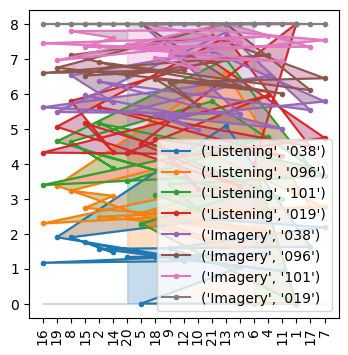

In [139]:
fig, ax = plt.subplots(figsize = (4,4))

y = np.zeros_like(df_pivot_norm['mean'][stim_order[0]])

for stim in stim_order:
    x = subjectIDs_in_asc_blink_sum
    del_y = df_pivot_norm['mean'].loc[x, stim]

    line, = plt.plot(
        x,
        y + del_y,
        marker='.',
        label = stim,
    )
    plt.fill_between(
        x,
        y,
        y + del_y,
        color = line.get_color(),
        alpha = .25, 
    )

    y += del_y

plt.legend(loc='best')
#plt.xticks(rotation=90)
plt.xticks(
    ticks = range(1, 21+1),
    labels= x, #range(1, 21+1),
    rotation = 90,
)
#plt.yscale('log')
plt.show()

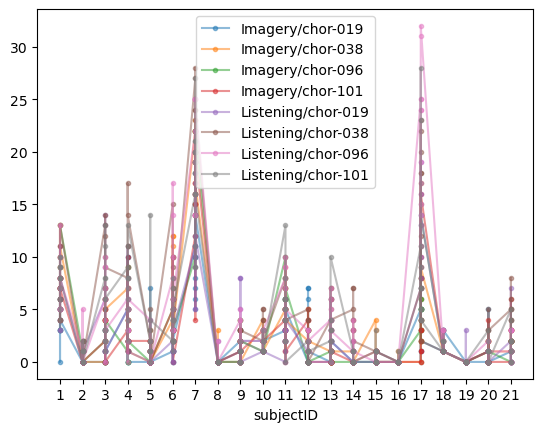

In [28]:
fig, ax = plt.subplots()

for name, group in df_all.groupby(['condition']):
    group.plot(
        x = 'subjectID',
        y = 'blinks',
        marker = '.',
        ls = '-',
        ax = ax,
        alpha = 0.5,
        label = name,
    )
plt.xticks(
    ticks = range(1, 21+1),
    labels= range(1, 21+1),
)

plt.show()

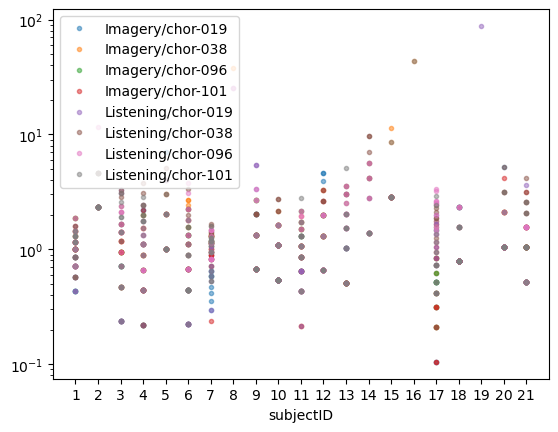

In [29]:
fig, ax = plt.subplots()

for name, group in df_all.groupby(['condition']):
    group.plot(
        x = 'subjectID',
        y = 'blinks_norm',
        marker = '.',
        ls = '',
        ax = ax,
        alpha = 0.5,
        label = name,
        logy = True,
    )

#plt.ylim([0, 10])
plt.xticks(
    ticks = range(1, 21+1),
    labels= range(1, 21+1),
)

plt.show()

(0.0, 5.0)

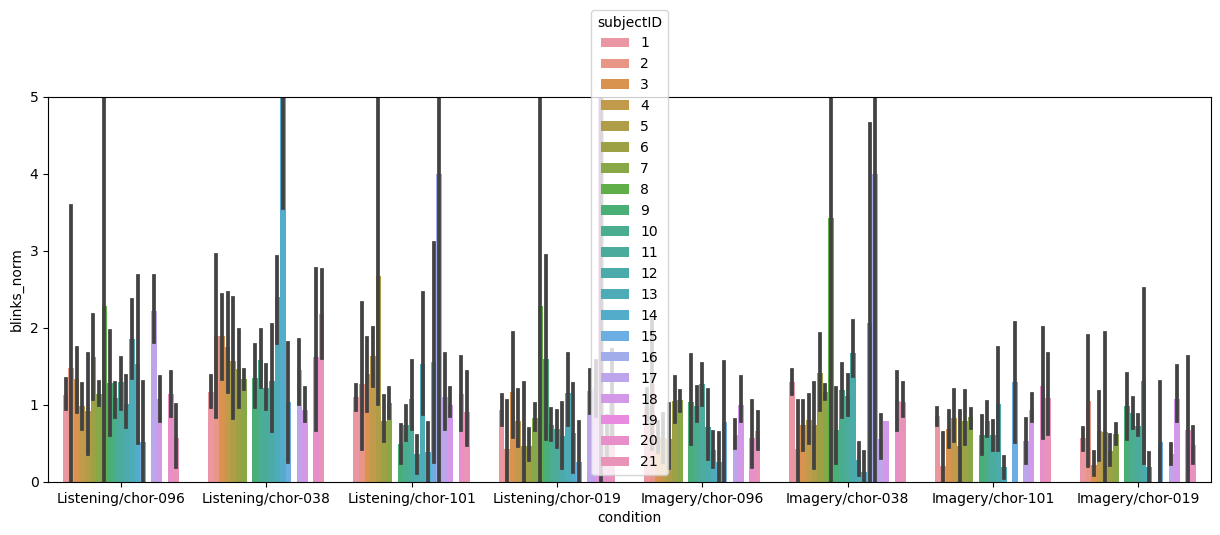

In [30]:
import seaborn as sb

# https://www.tutorialspoint.com/python-pandas-draw-vertical-bar-plots-with-nested-grouping-by-two-categorical-variables-in-seaborn


fig, ax = plt.subplots(figsize=(15, 5))

sb.barplot(
    x = df_all['condition'],
    y = df_all['blinks_norm'],
    hue = 'subjectID',
    data = df_all,
    ax = ax,
    #stacked = True,
)

ax.set_ylim([0, 5])

# Appendix

In [ ]:
# Taking in the subject data, each condition (see map) is the key for a
# blink value that is the number of blinks in the duration of the trial
npy_path = 'Subject1BlinksData.npy'
arr = np.load(npy_path, allow_pickle=True)
arr = arr.flat[0]

In [ ]:
# Numerical map for each of the song and listening or imagining conditions
Listeningchor96_Indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Imaginingchor96_Indexes = [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]

Listeningchor38_Indexes = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Imaginingchor38_Indexes = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

Listeningchor101_Indexes = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Imaginingchor101_Indexes = [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]

Listeningchor19_Indexes = [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Imaginingchor19_Indexes = [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

In [ ]:
# Creating 2D array with rows equal to the number of chors and conditions and cols equal to test number
ConditionArray = np.empty([len(chors),len(chors[1])], dtype=int)

# Filling 2D ndarray with blink info row corresponds to L/I + chor##
# and col is the number of blinks in one of the 11 trials
rowi = 0
for chorindexes in chors:

    coli = 0
    for key in chorindexes:
        ConditionArray[rowi, coli] = arr[key]
        coli += 1

    rowi += 1


# Running statistical analysis with student's t. Comparing each condition to all others
# Array for storing the tstatistic and pval results as a list with [tstat, pval]
StatArray_t = np.empty([8,8], dtype = list)
StatArray_p = np.empty([8,8], dtype = list)

# Conducting two-tailed t test as the null hypothesis is that there is difference between the distributions
# Each distribution will be compared against all other distributions, including itself
rowi = 0
for Row in ConditionArray:
    for trialIdx in range(len(Row)):
        if trialIdx == 0:
            alpha = 1
            trial, = plt.plot(
                rowi, Row[trialIdx], 
                '.', 
                alpha = alpha, #1-trialIdx/len(Row)
            )
        else:
            alpha = 1-trialIdx/len(Row)
            plt.plot(
                rowi, Row[trialIdx], 
                '.', 
                alpha = alpha,
                c=trial.get_color(),
            )
    plt.plot(rowi, np.mean(Row), 'x', c=trial.get_color())

    coli = 0
    for Col in ConditionArray:

        t_statistic, p_value = ttest_ind(Row, Col)
        
        StatArray_t[rowi, coli] = t_statistic
        StatArray_p[rowi, coli] = p_value
        coli += 1

    rowi += 1


# print(StatArray)


# Converting StatArray to a dataframe for easy analysis

df_t = pd.DataFrame(StatArray_t)
df_p = pd.DataFrame(StatArray_p)

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.ylabel('#Blinks')
plt.title(npy_path)
plt.show()

# Rename columns and rows for easy analysis
for df in [df_t, df_p]:
    df.rename(columns={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)

    df.rename(index={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)


    #print(df)

In [ ]:
df_t

In [ ]:
df_p

In [ ]:
plt.imshow(np.array(df_p < 0.05))
plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.yticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    #rotation='vertical'
)
plt.show()